# NLP processing

In [1]:
import pandas as pd
import regex, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aafo_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aafo_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aafo_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Load the plot summaries dataset

In [2]:
plots = pd.read_csv('./data/plot_summaries.txt', sep='\t', header=None) 
plots.columns = ['movie_id', 'plot_summary']

Text preprocessing pipeline. Stopword filtering, non alphanumerical string filtering, duplicate filtering and lemmatization.

In [12]:
def text_preprocessing_pipeline(x, reg, stopwords, lemmatizer):
    return " ".join([lemmatizer(w) for w in 
            set(word_tokenize(reg.sub('', x).lower().strip()))
            if w not in stopwords and w.isalpha()])

In [13]:
reg = regex.compile('[%s]' % regex.escape(string.punctuation))
stopw = list(stopwords.words('english'))
lemmatizer = WordNetLemmatizer().lemmatize

Apply the pipeline

In [20]:
plots.plot_summary = plots.plot_summary.apply(
    text_preprocessing_pipeline,
    reg = reg, stopwords = stopw, lemmatizer = lemmatizer)

In [21]:
plots.plot_summary

0        taxi saxophonist different hardworking develop...
1        haymitchs overhearing dodge pin supply wealth ...
2        aishwarya party daughter accused sentenced dys...
3        outside charmed free visit retirement reimburs...
4        new daughter accused sentenced country insiste...
                               ...                        
42298    poetry muslim english malayalam medium young m...
42299    soldier token cousin amusement dressing differ...
42300    requires testament aspiring never different ta...
42301    daughter amina realises decides also good sell...
42302    aim nobody comically weather flag eden river c...
Name: plot_summary, Length: 42303, dtype: object

In [23]:
#plots.to_csv('./data/plot_summaries_preprocessed.csv', index = False)

# NLP processed + Movie_metadata join

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import FactorAnalysis
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt

In [2]:
plots = pd.read_csv('./data/plot_summaries_preprocessed.csv')
plots.columns = ['movie_id', 'plot_summary']

Factor analysis is made on the word frequency matrix. The aim of this analysis is to try and represent the matrix distribution as ``number of factors`` linear combinations of each of the word frequency over document. So, the loads represent its weight per factor. And taking a certain number of words equally per factor would yield the most representative words that explain the frequency distribution per factor.

In [19]:
fact = 3
fa = FactorAnalysis(fact)

# Create the bag of words of corpus
vectorizer = TfidfVectorizer(max_features = 2000)
fa.fit(vectorizer.fit_transform(plots.plot_summary).toarray())

FactorAnalysis(n_components=3)

In [20]:
# Extract factor loads of analysis.
factorWeights = pd.DataFrame(fa.components_.T, index = list(vectorizer.vocabulary_.keys()),
                                columns = [x+1 for x in range(0, fact)])
factorWeights.head()

,1,2,3
taxi,0.000958,0.000240,-0.000916
different,0.001682,0.000826,0.000156
develop,0.001321,0.001062,-0.000368
driver,0.003952,0.000604,-0.001261
relationship,0.001261,0.002207,-0.000506


In [21]:
# Keep the 100 most important words per factor.
categories = {}
number_of_words = 100
for f in range(1,fact+1):
  temp = factorWeights[f].abs().sort_values(ascending = False)[:number_of_words]
  categories[str(f)] = ", ".join(list(temp.index))

In [22]:
factorAnalysisResults = pd.Series(categories)

In [23]:
# Display most representative words per factor.
for x in range(len(factorAnalysisResults)):
    print(f"Factor {x+1}")
    print(factorAnalysisResults[x])

Factor 1
demon, people, guide, help, door, god, movie, name, test, drunken, embrace, rape, patient, hall, writing, unexpectedly, host, causing, decline, attorney, leave, artist, hour, chase, sense, prof, attend, unknown, mexico, teenage, accompanied, time, flee, pain, station, ball, happen, post, hang, actress, offered, dead, accidentally, six, opening, could, someone, manages, cat, traveling, destroyed, drive, sing, fortune, section, return, reluctant, sergeant, incident, native, introduces, price, moment, war, american, initially, drama, card, depressed, celebration, romance, situation, somehow, heavily, decide, forcing, confronts, direction, telling, shown, least, four, gay, brutal, practice, kept, following, burning, ride, furious, estate, producer, throw, check, safety, figure, angrily, extremely, seat, simply
Factor 2
resort, decline, written, promised, tied, peter, favorite, embrace, standing, apart, time, director, investigate, hall, knocking, mary, chief, heavily, authority, p

In [25]:
# Per plot summary assign the most representative factor (word summary plot hits on factor most representative words)
def get_factor(plot):
    occurrences = dict(zip(factorAnalysisResults.index, [0]*len(factorAnalysisResults.index)))
    for word in plot.split():
        for x in occurrences:
            if word in factorAnalysisResults[x]:
                occurrences[x]+=1

    return max(occurrences, key = occurrences.get)

In [26]:
plots["factor"] = plots.plot_summary.apply(get_factor).astype(int)

In [27]:
plots

,movie_id,plot_summary,factor
0,23890098,taxi saxophonist different hardworking develop...,1
1,31186339,haymitchs overhearing dodge pin supply wealth ...,1
2,20663735,aishwarya party daughter accused sentenced dys...,3
3,2231378,outside charmed free visit retirement reimburs...,2
4,595909,new daughter accused sentenced country insiste...,3
...,...,...,...
42298,34808485,poetry muslim english malayalam medium young m...,2
42299,1096473,soldier token cousin amusement dressing differ...,3
42300,35102018,requires testament aspiring never different ta...,2
42301,8628195,daughter amina realises decides also good sell...,2


A previous version of the dataset is loaded and merged with the results obtained before

In [28]:
movie_metadata = pd.read_csv('./data/movie_metadata_clean.csv').set_index('movie_id')
movie_metadata_factor = pd.merge(movie_metadata, plots.set_index('movie_id')["factor"], right_index = True, left_index = True)

<ipython-input-28-10b17e994461>:1: DtypeWarning: Columns (15,16,17,18,19,20,29,30,31,32,33,34,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv('./data/movie_metadata_clean.csv').set_index('movie_id')


We plot the overall distribution of genres countries and languages

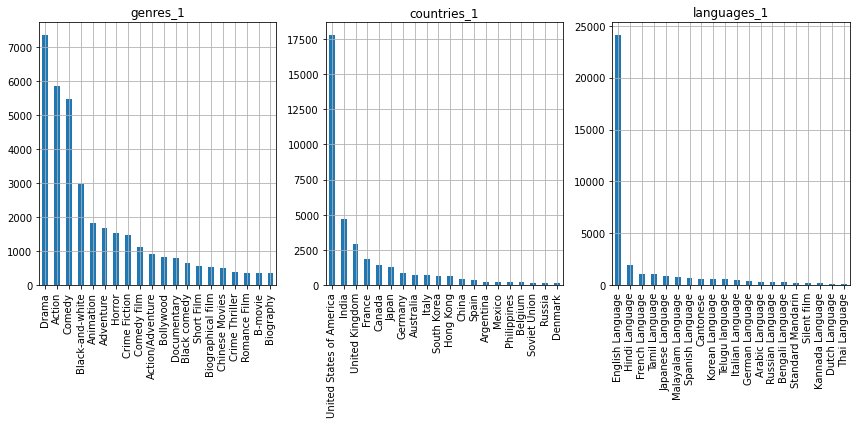

In [31]:
fig, ax = plt.subplots(1, 3, figsize =(12,6))
ax = ax.flatten()
for i, col in enumerate(["genres_1", "countries_1", "languages_1"]):
    movie_metadata_factor[col].value_counts()[:20].plot.bar(ax = ax[i])
    ax[i].set(title = col)
    ax[i].grid()

plt.tight_layout()

plt.savefig('./figs/general_proportions.jpeg')
plt.show()

The following plots represent the non-shared categories per factor after taking the 100 most present categories per feature.

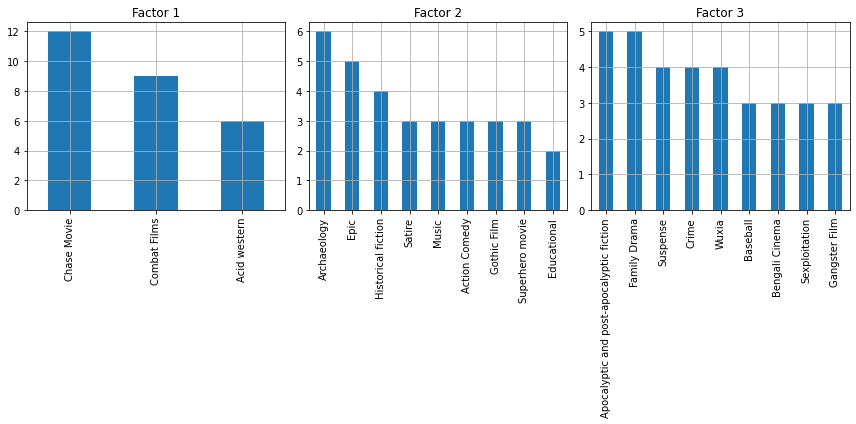

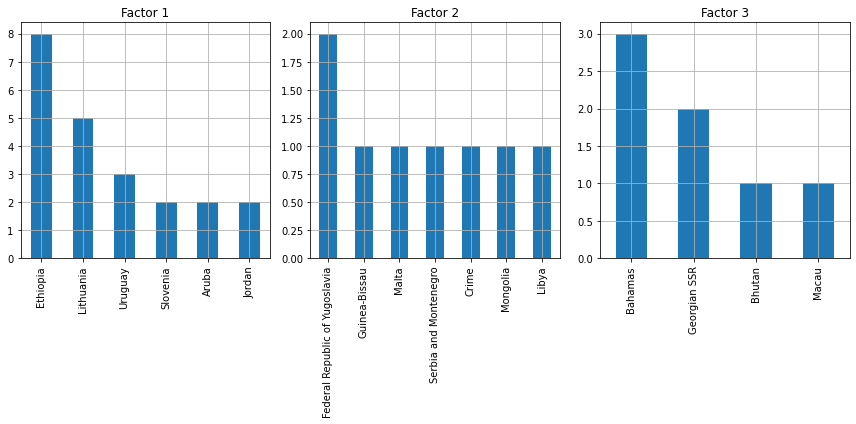

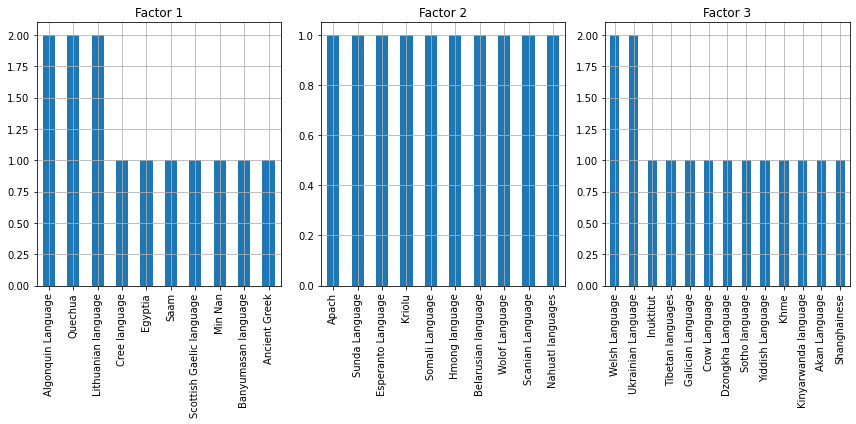

In [34]:
ncol = 3
n_vals = 100
nrow = plots.factor.max() // ncol if plots.factor.max() % ncol == 0 else plots.factor.max() // ncol +ncol

for col in ["genres_1", "countries_1", "languages_1"]:

    fig, ax = plt.subplots(nrow, ncol, figsize =(12,6))
    ax = ax.flatten()
    
    dfs = []
    for factor, df in movie_metadata_factor.groupby('factor')[col]:
        dfs.append(df.value_counts().sort_values(ascending = False)[:n_vals])
    
    
    for i, temp_df in enumerate(dfs):
        
        to_plot = temp_df.index
        
        all_index = [dfs[k].index.tolist() for k in range(len(dfs)) if k!= i]
        
        indexes = []
        for ls in all_index:
            indexes += ls
        
        to_plot = [x for x in temp_df.index if x not in indexes]
        
        try:
            temp_df[to_plot].plot.bar(ax = ax[i])
            ax[i].grid()
            ax[i].set(title = f"Factor {i+1}")
        except:
            print(f"{col}: change number of vals: {n_vals}, factor {i} wont plot")


    plt.tight_layout()

    plt.savefig(f'./figs/{col}_by_factor_3_filtered.jpeg')
    plt.show()

We observe that the difference between separated movies by factor is not very representative. As we only get very few non shared categories out of 100 tested. We conclude with this analysis that the word distribution in plot summaries alone does not lead us to a proper observable separation of movies.